In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
import pydot
import graphviz
import tensorflow as tf
import tiffile as tif
from PIL import Image

In [2]:
print(keras.__version__)
print(tf.__version__)

3.2.1
2.16.1


In [25]:
# Function that takes a tiff image and pads it to the desired size (square) and returns a numpy array
def pad_image(image, size):
    # load the image
    img = tif.imread(image)
    # get image dimensions
    x,y = img.shape
    # calculate the padding
    x_pad = size - x
    y_pad = size - y
    # check if padding is needed, if not, resize the image maintaining aspect ratio
    if x_pad < 0 or y_pad < 0:
        if x > y:
            new_x = size
            new_y = int(y * (size/x))
        else:
            new_y = size
            new_x = int(x * (size/y))
        img = np.array(Image.fromarray(img).resize((new_y, new_x)))
        x,y = img.shape
        x_pad = size - x
        y_pad = size - y
    # pad the image
    if x_pad > 0 or y_pad > 0:
        x_pad1, x_pad2 = x_pad//2, x_pad-x_pad//2
        y_pad1, y_pad2 = y_pad//2, y_pad-y_pad//2
        img = np.pad(img, ((x_pad1, x_pad2), (y_pad1, y_pad2)), 'constant')
    return img

# Function that takes a folder and pads each image in the folder. Inputs are the input path, output path.
def pad_folder(input_path, output_path, size):
    # make the output path
    os.makedirs(output_path, exist_ok=True)
    subfolders = [f.path for f in os.scandir(input_path) if f.is_dir()]
    for folder in subfolders:
        # use base folder name as class
        class_name = os.path.basename(folder)
        # make the output class folder
        os.makedirs(os.path.join(output_path, class_name), exist_ok=True)
        # get all the images in the folder
        images = [f.path for f in os.scandir(folder) if f.is_file()]
        for img in images:
            # input image path
            img_in_path = img
            # output image path
            img_out_path = os.path.join(output_path, class_name, os.path.basename(img))
            img_out_path = img_out_path.replace('.tif', '.bmp')
            # print statment
            print(f"Padding {img_in_path} to {img_out_path}")
            # pad the image and save it
            try:
                img_output = pad_image(image=img_in_path, size=size)
                # write img as bmp
                im = Image.fromarray(img_output)
                im.save(img_out_path)
            except Exception as e:
                print("failed to pad image", img_in_path, e)

In [26]:
#pad_folder(input_path='datasets/testing', output_path="datasets/padded_testing", size=256)
#pad_folder(input_path='datasets/training', output_path="datasets/padded_training", size=256)

Padding datasets/testing/dinoflagellate/2005_055_060729_695.tif to datasets/padded_testing/dinoflagellate/2005_055_060729_695.bmp
Padding datasets/testing/dinoflagellate/2005_054_051556_316.tif to datasets/padded_testing/dinoflagellate/2005_054_051556_316.bmp
Padding datasets/testing/dinoflagellate/2005_090_112447_1650.tif to datasets/padded_testing/dinoflagellate/2005_090_112447_1650.bmp
Padding datasets/testing/dinoflagellate/2005_058_054103_252.tif to datasets/padded_testing/dinoflagellate/2005_058_054103_252.bmp
Padding datasets/testing/dinoflagellate/2005_055_060729_952.tif to datasets/padded_testing/dinoflagellate/2005_055_060729_952.bmp
Padding datasets/testing/dinoflagellate/2005_048_204334_52.tif to datasets/padded_testing/dinoflagellate/2005_048_204334_52.bmp
Padding datasets/testing/dinoflagellate/2005_048_204334_91.tif to datasets/padded_testing/dinoflagellate/2005_048_204334_91.bmp
Padding datasets/testing/dinoflagellate/2005_061_075402_1326.tif to datasets/padded_testing/

In [47]:
image_size = (256, 256)
batch_size = 32
train_ds = keras.utils.image_dataset_from_directory("datasets/padded_training",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=image_size,
                                                            batch_size=batch_size)
val_ds = keras.utils.image_dataset_from_directory("datasets/padded_testing",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=image_size,
                                                            batch_size=batch_size)

Found 3300 files belonging to 22 classes.


Found 3298 files belonging to 22 classes.


2024-04-15 14:50:07.438850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


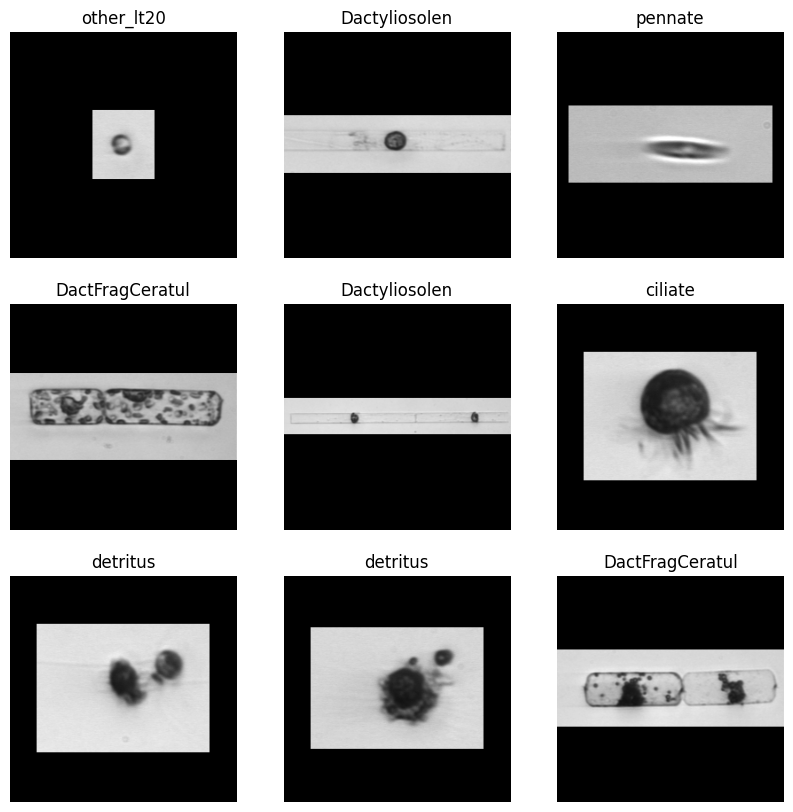

In [29]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(train_ds.class_names[tf.argmax(labels[i])])
        plt.axis("off")

2024-04-15 14:52:04.619018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


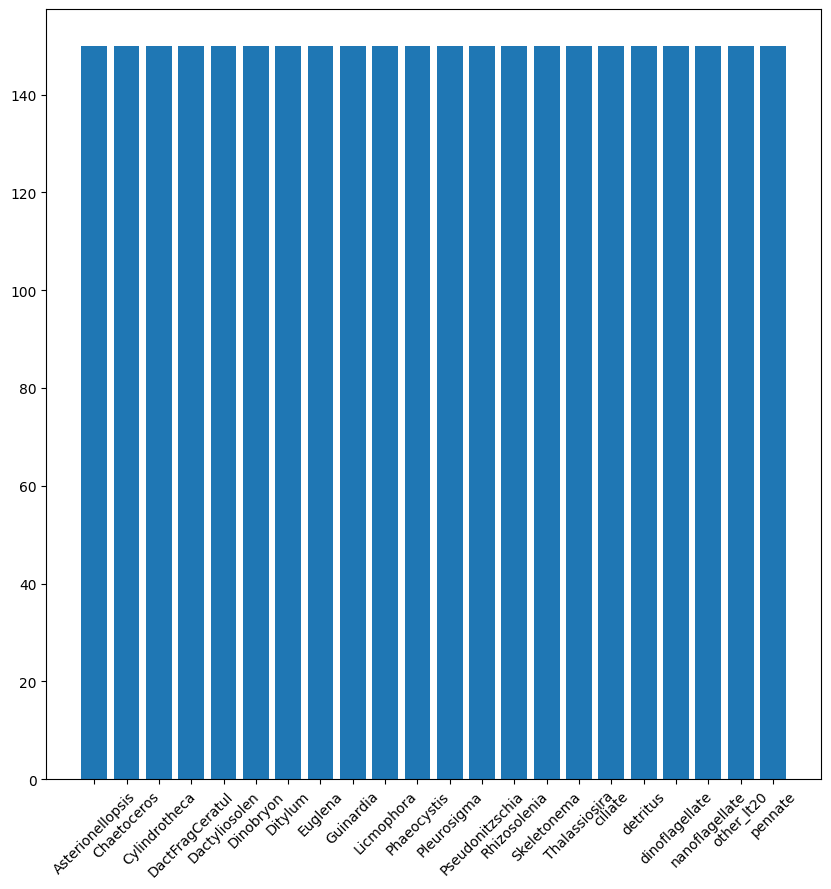

In [31]:
# Get distribution of labels as a bar chart. This demonstrates that the dataset is balanced.
class_labels = train_ds.class_names
label_counts = {}

for images, labels in train_ds:
    for label in labels:
        label_index = tf.argmax(label).numpy()
        class_name = class_labels[label_index]  # Get the class name
        if class_name in label_counts:
            label_counts[class_name] += 1
        else:
            label_counts[class_name] = 1
# plot the distribution
plt.figure(figsize=(10, 10))
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(range(len(label_counts)), train_ds.class_names, rotation=45)
plt.show()

In [34]:
for images, labels in train_ds.take(1):
    print(images[1].shape)
    print(labels[1].shape)

(256, 256, 3)
(22,)


2024-04-15 15:01:13.486975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Start with the example "image classification from scratch" XCeption network, from keras [examples](https://keras.io/examples/vision/image_classification_from_scratch/)

In [49]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=image_size + (3,), num_classes=22)
# keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 256, 256,  │          0 │ input_layer_8[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 128, 128,  │      3,584 │ rescaling_8[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 128, 128,  │          0 │ activation_64[0]… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_56 │ (None, 128, 128,  │     34,176 │ activation_65[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_57 │ (None, 128, 128,  │     68,096 │ activation_66[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 64, 64,    │     33,024 │ activation_64[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 64, 64,    │          0 │ max_pooling2d_24… │
│                     │ 256)              │            │ conv2d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_67       │ (None, 64, 64,    │          0 │ add_24[0][0]      │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_58 │ (None, 64, 64,    │    133,888 │ activation_67[0]… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      2,048 │ separable_conv2d

 Total params: 2,752,590 (10.50 MB)

 Trainable params: 2,744,302 (10.47 MB)

 Non-trainable params: 8,288 (32.38 KB)

In [54]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25


: 